In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from matplotlib.gridspec import GridSpec
from sklearn import metrics
import seaborn as sns


In [19]:
df_lol = pd.read_csv('..\\data\\interim\\lol_clean_data.csv')


In [20]:
df_lol.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9879 entries, 0 to 9878
Data columns (total 37 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   blueWins                      9879 non-null   int64  
 1   blueWardsPlaced               9879 non-null   int64  
 2   blueWardsDestroyed            9879 non-null   int64  
 3   blueFirstBlood                9879 non-null   int64  
 4   blueKills                     9879 non-null   int64  
 5   blueDeaths                    9879 non-null   int64  
 6   blueAssists                   9879 non-null   int64  
 7   blueDragons                   9879 non-null   int64  
 8   blueHeralds                   9879 non-null   int64  
 9   blueTowersDestroyed           9879 non-null   int64  
 10  blueTotalGold                 9879 non-null   int64  
 11  blueAvgLevel                  9879 non-null   float64
 12  blueTotalExperience           9879 non-null   int64  
 13  blu

In [21]:
df_lol.head()

,blueWins,blueWardsPlaced,blueWardsDestroyed,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueDragons,blueHeralds,blueTowersDestroyed,...,redTowersDestroyed,redTotalGold,redAvgLevel,redTotalExperience,redTotalMinionsKilled,redTotalJungleMinionsKilled,redGoldDiff,redExperienceDiff,redCSPerMin,redGoldPerMin
0,0,28,2,1,9,6,11,0,0,0,...,0,16567,6.8,17047,197,55,-643,8,19.7,1656.7
1,0,12,1,0,5,5,5,0,0,0,...,1,17620,6.8,17438,240,52,2908,1173,24.0,1762.0
2,0,15,0,0,7,11,4,1,0,0,...,0,17285,6.8,17254,203,28,1172,1033,20.3,1728.5
3,0,43,1,0,4,5,5,0,1,0,...,0,16478,7.0,17961,235,47,1321,7,23.5,1647.8
4,0,75,4,0,6,6,6,0,0,0,...,0,17404,7.0,18313,225,67,1004,-230,22.5,1740.4


# Explore
We'll examine if there are any redundant feature in our datasets and if there is any high multicollinearity that we might need to address. 

In [48]:
# Create functions to easily visualize correlation as well as general
# data distribution and outliers.


def corr_heatmap(df_lol, digits=3, cmap='RdYlGn'):

    # Create correlation matrix from dataframe
    correl = df_lol.corr().round(digits)
    correl

    # Create mask for upper triangle of matrix
    mask = np.zeros_like(correl)
    mask[np.triu_indices_from(mask)] = True

    #Create heatmap correlation matrix
    fig, ax = plt.subplots(figsize=((len(df_lol.columns)), (len(df_lol.columns))))
    sns.heatmap(correl, annot=True, ax=ax, cmap=cmap, vmin=-1, vmax=1,
                mask=mask)
    return fig, ax


def visual_eda(df_lol, target, col):
   
    # Create copy variables of df and col
    data = df_lol[col].copy()
    name = col

    # Calc mean and mean
    median = data.median()
    mean = data.mean()

    # Create gridspec for plots
    fig = plt.figure(figsize=(11, 6))
    gs = GridSpec(nrows=2, ncols=2)

    ax0 = fig.add_subplot(gs[0, 0])
    ax1 = fig.add_subplot(gs[1, 0])
    ax2 = fig.add_subplot(gs[:, 1])

    # Plot distribution
    sns.histplot(data, alpha=0.5, stat='density', ax=ax0)
    sns.kdeplot(data, color='green', label='KDE', ax=ax0)
    ax0.set(ylabel='Density', title=name)
    ax0.set_title(F"Distribution of {name}")
    ax0.axvline(median, label=f'median={median:,}', color='black')
    ax0.axvline(mean, label=f'mean={mean:,}', color='black', ls=':')
    ax0.legend()

    # Plot Boxplot
    sns.boxplot(data, x=col, ax=ax1)
    ax1.set_title(F"Box Plot of {name}")

    # Plot Scatterplot to illustrate linearity
    sns.regplot(data=df_lol, x=col, y=target, line_kws={"color": "red"}, ax=ax2)
    ax2.set_title(F"Scatter Plot of {name}")

    # Tweak Layout & Display
    fig.tight_layout()

    return fig, gs


(<Figure size 2664x2664 with 2 Axes>, <AxesSubplot:>)

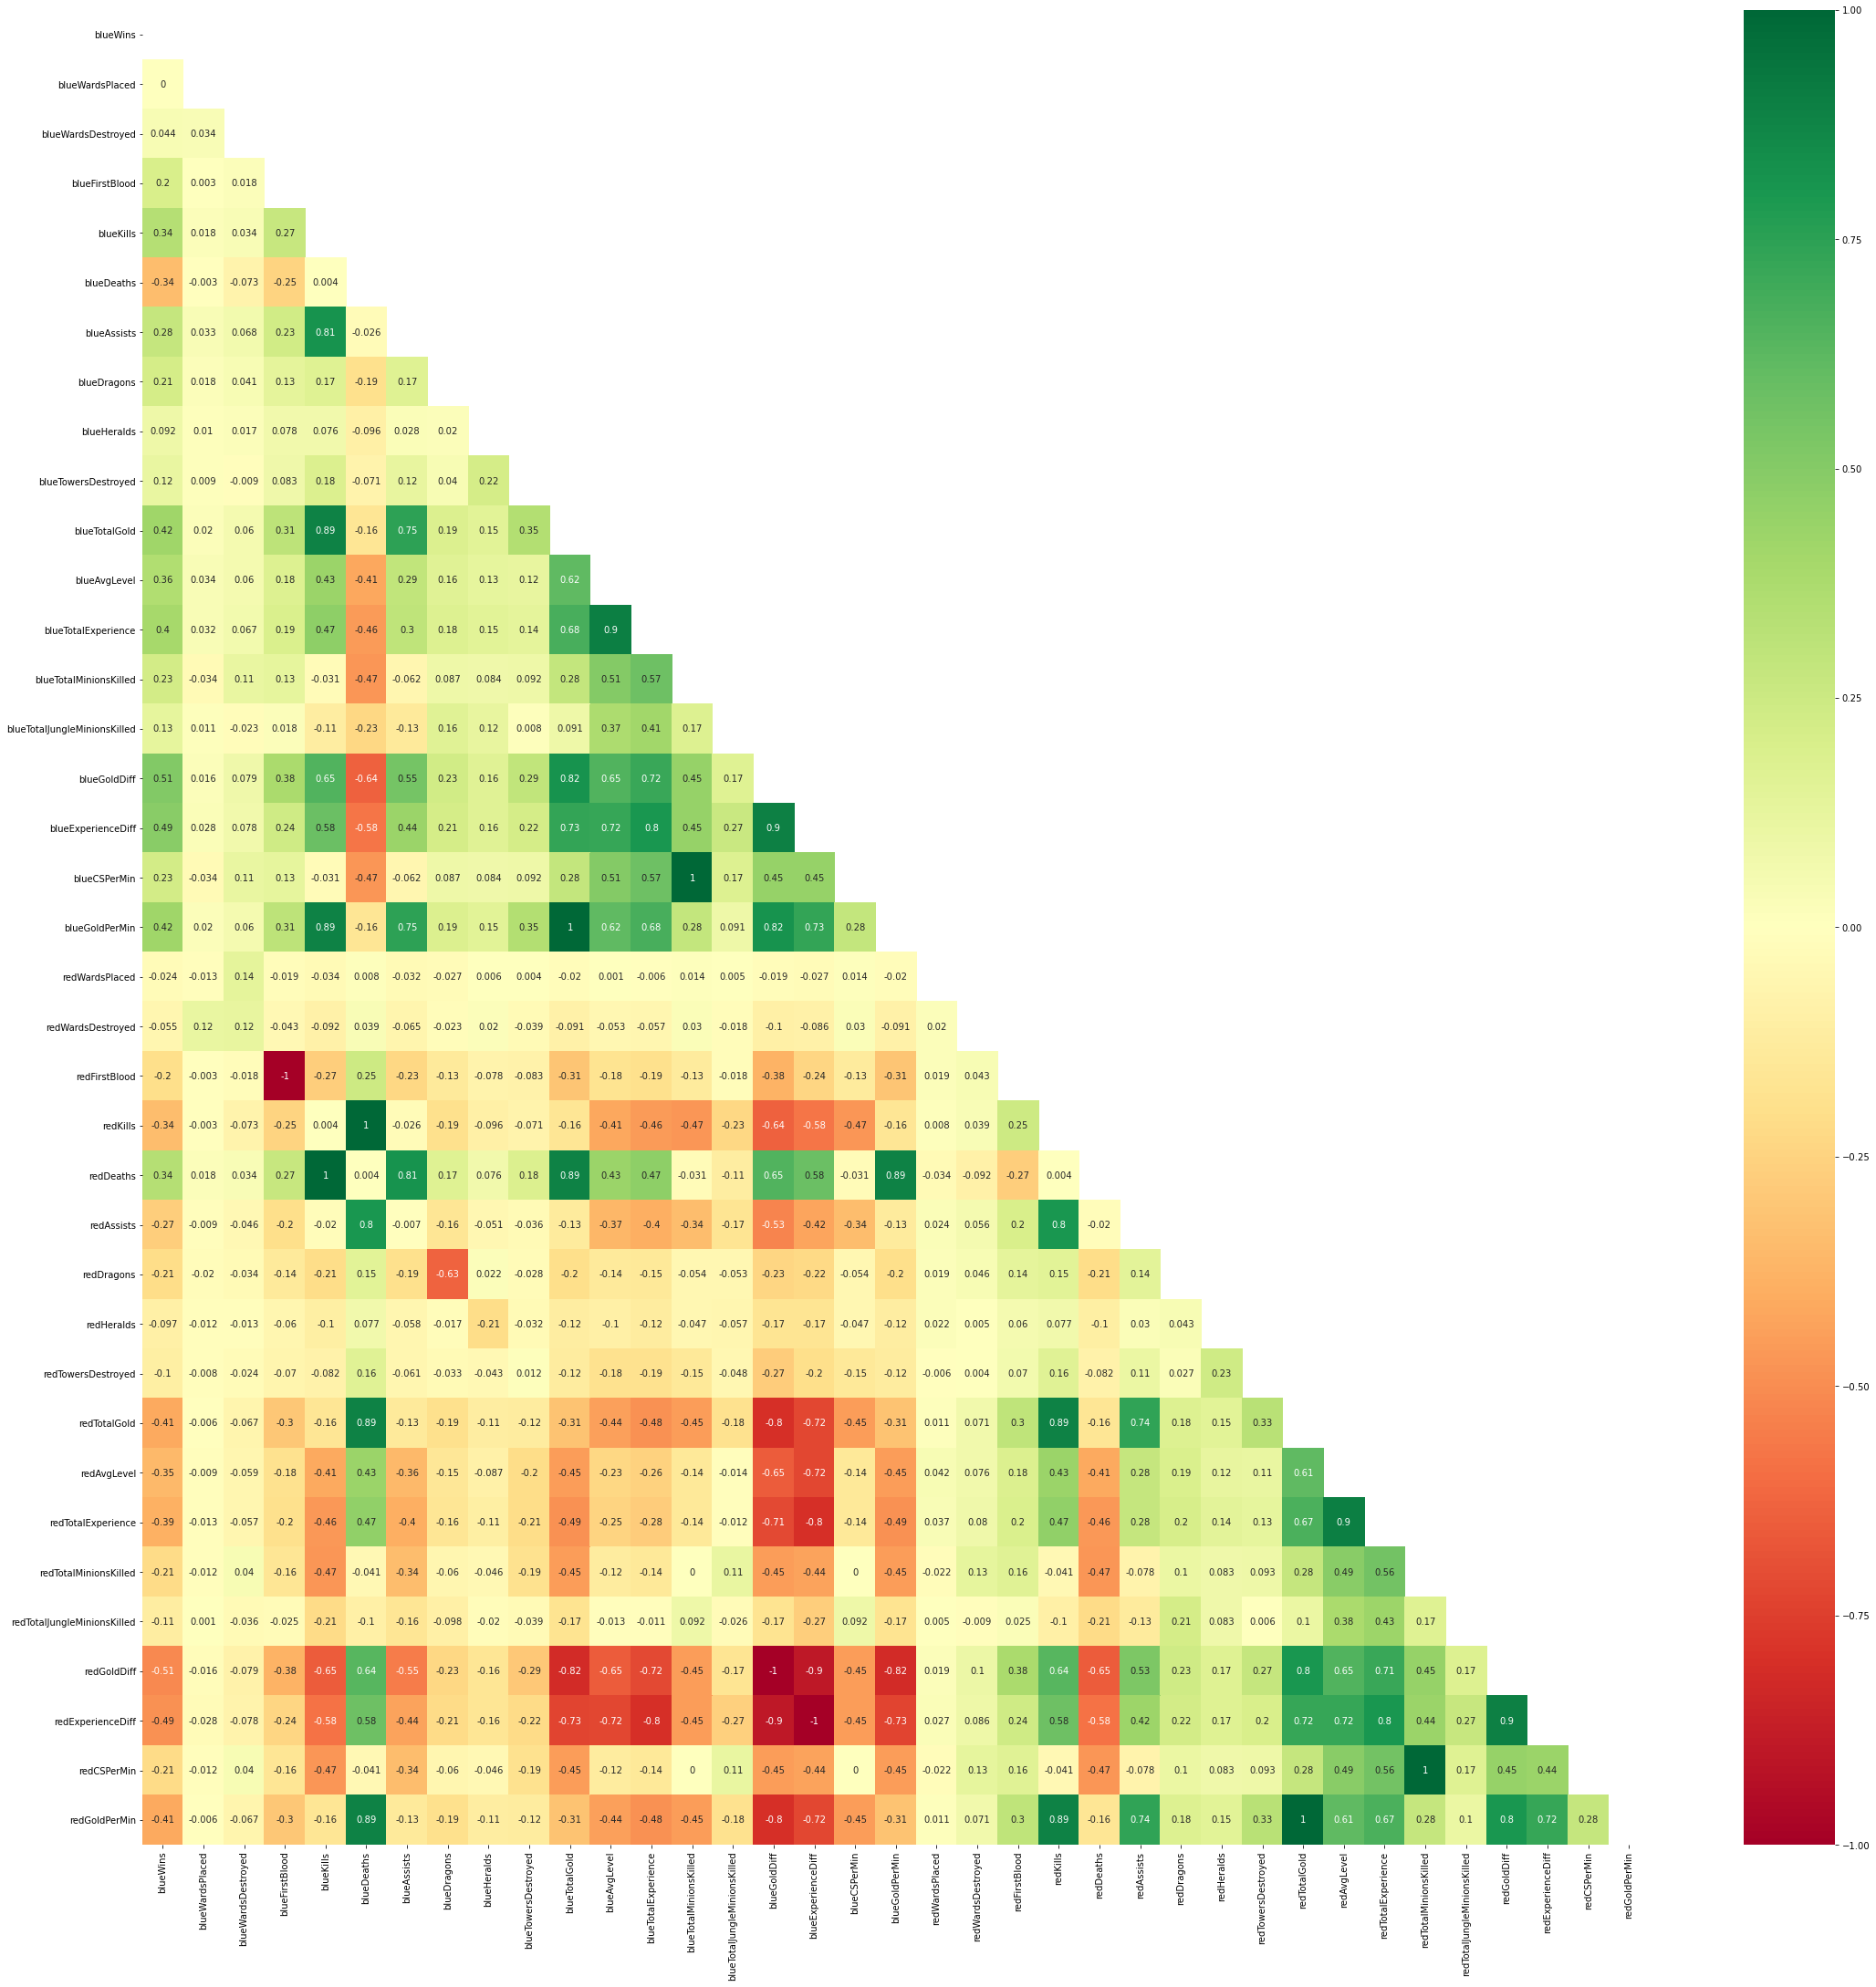

In [24]:
corr_heatmap(df_lol)



We can see that there are multiple features that have high multicollinearity. This is a big problem when considering a logistic regression, and so we will avoid using df_big for our logistic regression model.


In [35]:
# Select only variable directly controllable aspects of the game
df_select = df_lol[['blueWins', 'blueWardsPlaced', 'blueWardsDestroyed', 'blueFirstBlood',
                    'blueKills', 'blueDeaths', 'blueAssists', 'blueDragons', 'blueHeralds',
                    'blueTowersDestroyed', 'blueTotalMinionsKilled',
                    'blueTotalJungleMinionsKilled', 'redWardsPlaced', 'redWardsDestroyed',
                    'redAssists', 'redDragons', 'redHeralds', 'redTowersDestroyed',
                    'redTotalMinionsKilled', 'redTotalJungleMinionsKilled']]


(<Figure size 1440x1440 with 2 Axes>, <AxesSubplot:>)

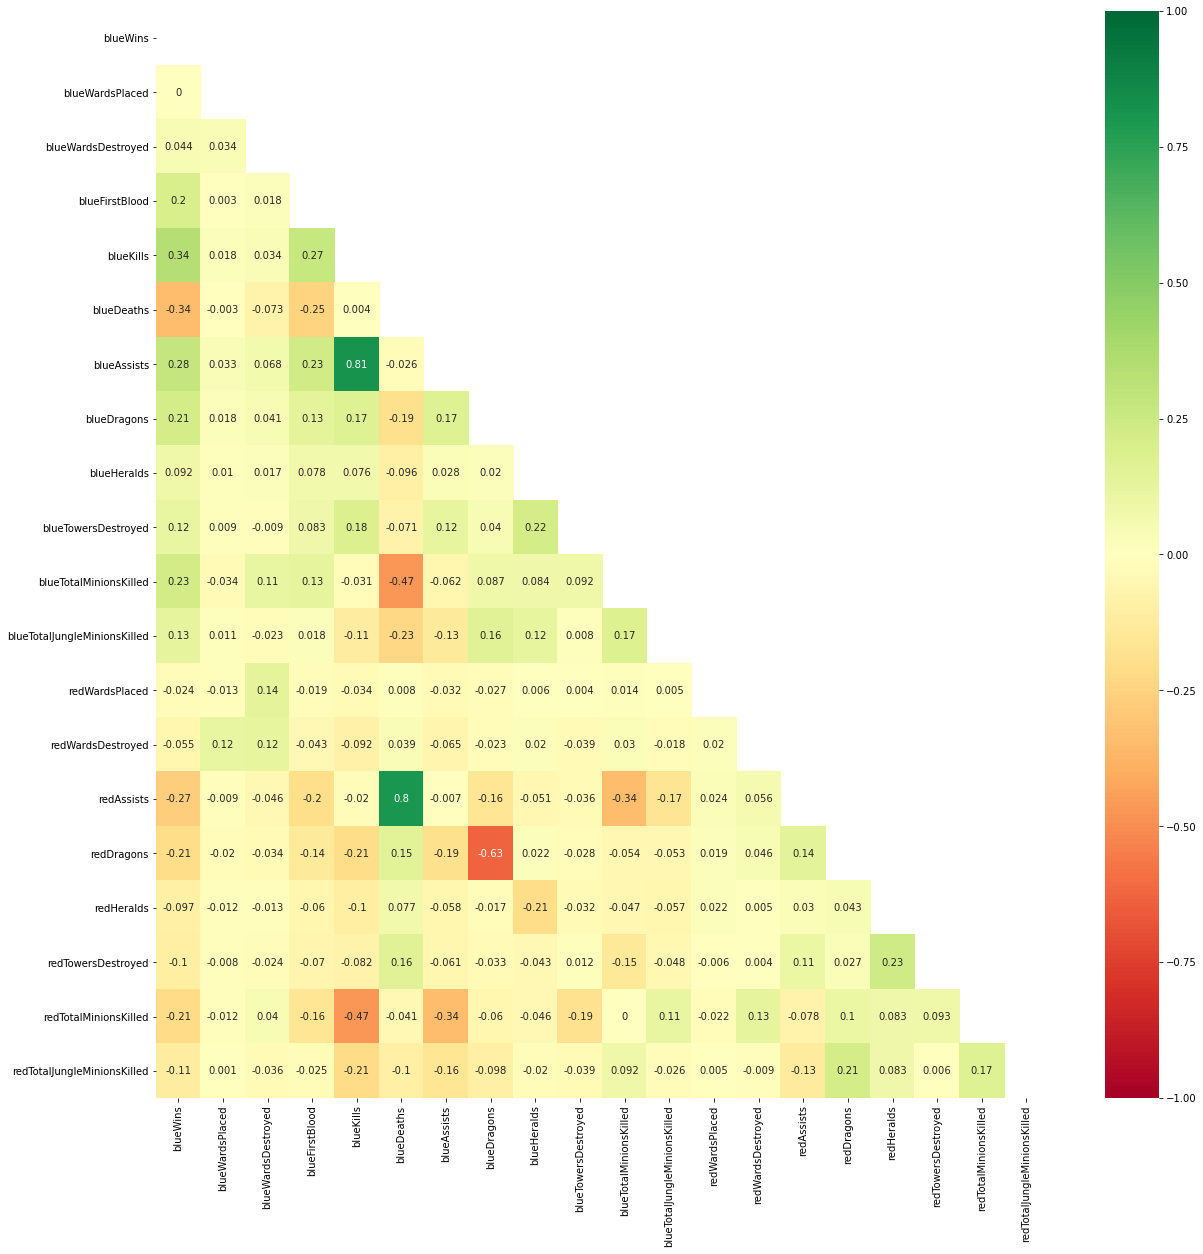

In [36]:
corr_heatmap(df_select)


We can see that there are some features with perfect mulicollinearity: redFirstBlood, redKills, and redDeaths which are inverse of blueFristBlood, blueDeaths, and blueKills. We'll remove the reds teams columns. 

In [17]:
df_lol.drop(columns=['redKills', 'redDeaths', 'redFirstBlood'],
               inplace=True)
df_lol.columns


Index(['blueWins', 'blueWardsPlaced', 'blueWardsDestroyed', 'blueFirstBlood',
       'blueKills', 'blueDeaths', 'blueAssists', 'blueDragons', 'blueHeralds',
       'blueTowersDestroyed', 'blueTotalGold', 'blueAvgLevel',
       'blueTotalExperience', 'blueTotalMinionsKilled',
       'blueTotalJungleMinionsKilled', 'blueGoldDiff', 'blueExperienceDiff',
       'blueCSPerMin', 'blueGoldPerMin', 'redWardsPlaced', 'redWardsDestroyed',
       'redAssists', 'redDragons', 'redHeralds', 'redTowersDestroyed',
       'redTotalGold', 'redAvgLevel', 'redTotalExperience',
       'redTotalMinionsKilled', 'redTotalJungleMinionsKilled', 'redGoldDiff',
       'redExperienceDiff', 'redCSPerMin', 'redGoldPerMin'],
      dtype='object')

(<Figure size 1440x1440 with 2 Axes>, <AxesSubplot:>)

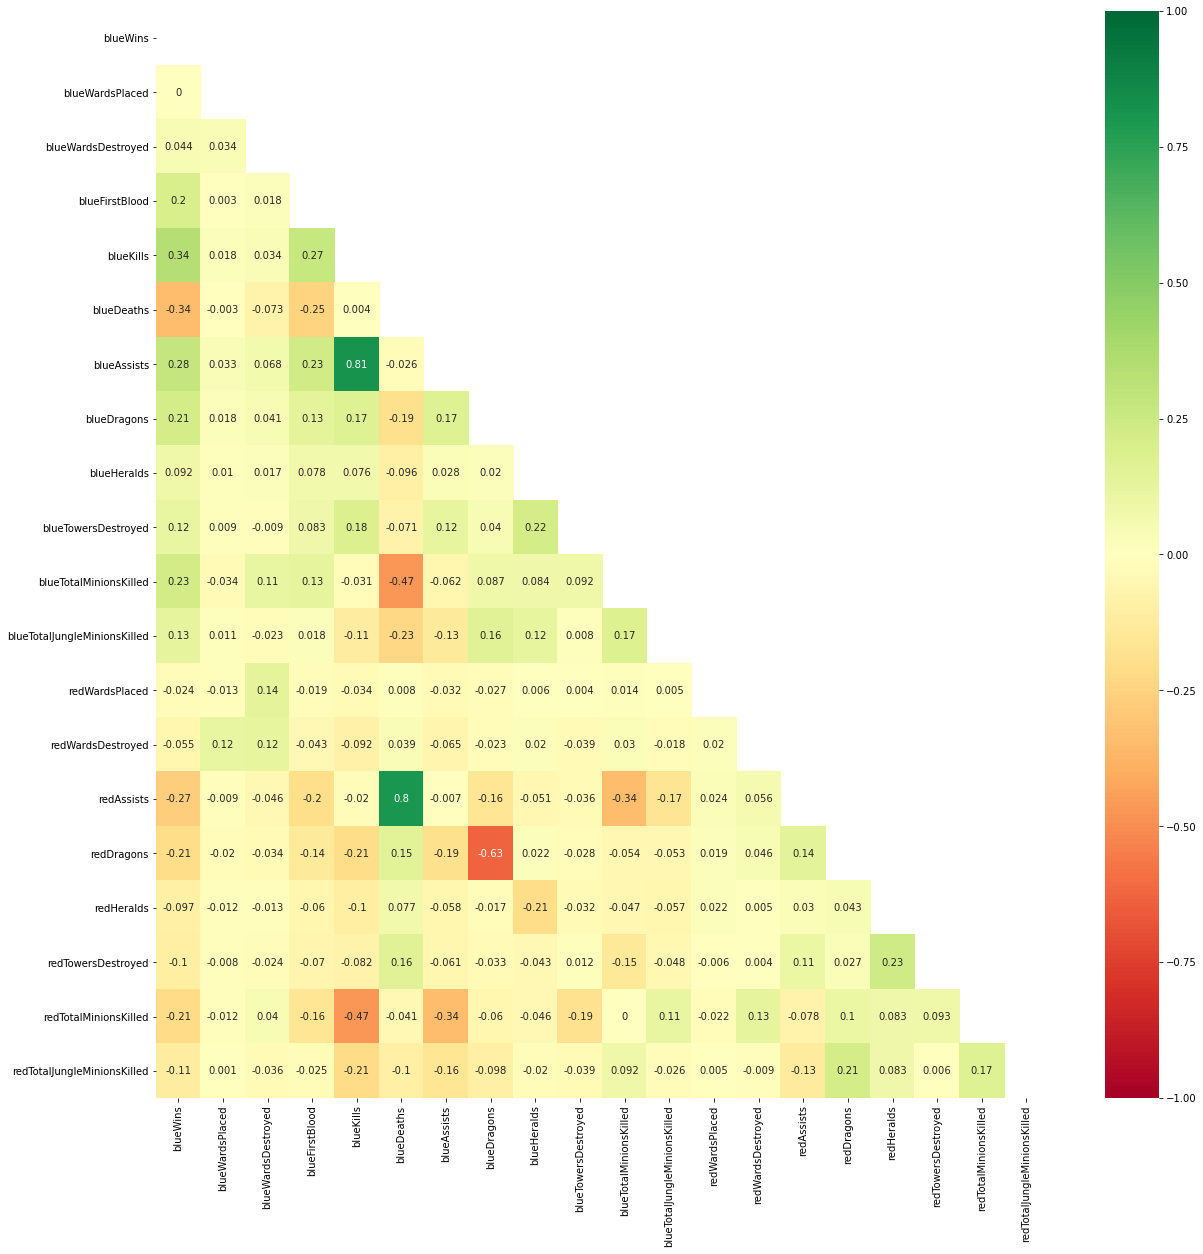

In [37]:
corr_heatmap(df_select)

As, we can see in the heatmap redAssists and blueAssist do have somewhat high correlation with blueDeaths and blueKills respectively, we will leave those features in our datagrame since the correlation coefficients are not too high, and the impact of assists on the match outcome is still important. 

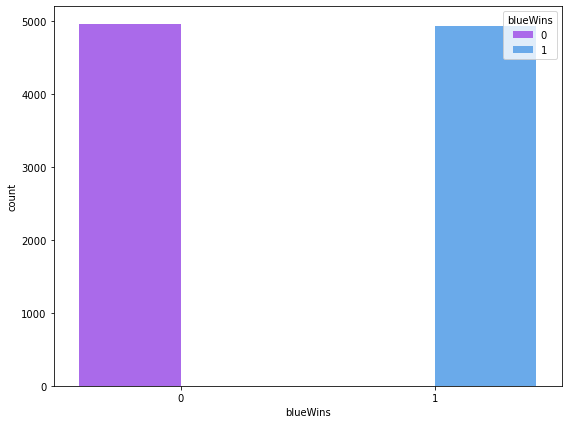

In [49]:


# Plot histogram
fig, ax = plt.subplots(figsize=(8, 6))
# sns.histplot(x='blueWins', data=diff_df, hue='blueWins', palette='Set1',bins=(2), kde=False)
sns.countplot(x='blueWins', data=df_select, hue='blueWins', palette='cool_r')

# Save as image
plt.tight_layout()



We can also see that we do not have an issue of class imbalance in this dataset.

Next, we will examine the general distribution how the total experience and gold are correlated with our target variable in addition to their distributions and outliers.


C:\Users\luisr\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


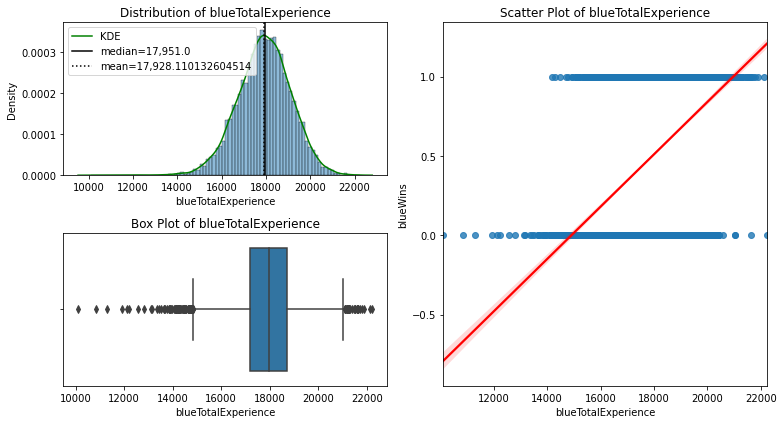

In [50]:
# Plot visualization for blueTotalExperience vs blueWins.
visual_eda(df_lol, 'blueWins', 'blueTotalExperience');


C:\Users\luisr\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


(<Figure size 792x432 with 3 Axes>, GridSpec(2, 2))

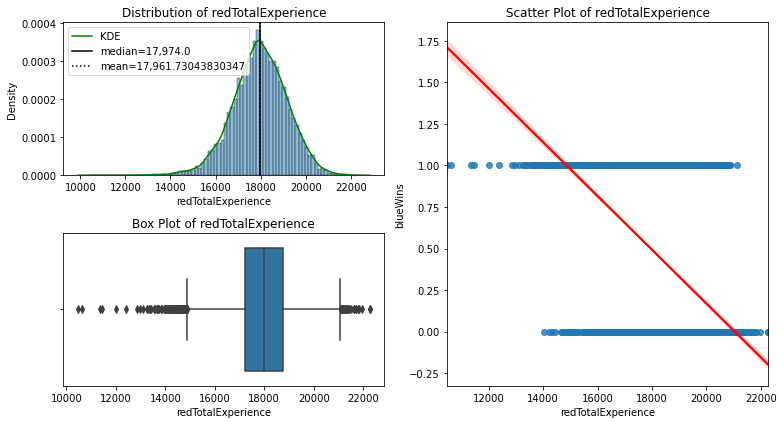

In [52]:
# Plot visualization for redTotalExperience vs blueWins.
visual_eda(df_lol, 'blueWins', 'redTotalExperience')


C:\Users\luisr\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


(<Figure size 792x432 with 3 Axes>, GridSpec(2, 2))

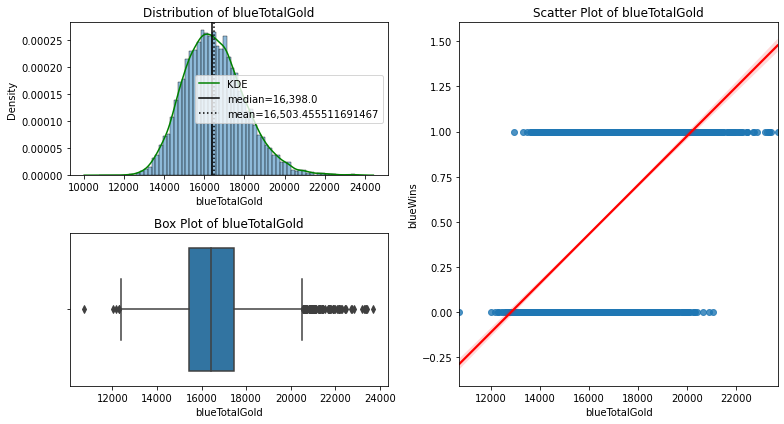

In [54]:
# Plot visualization for blueTotalGold vs blueWins.
visual_eda(df_lol, 'blueWins', 'blueTotalGold')


C:\Users\luisr\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


(<Figure size 792x432 with 3 Axes>, GridSpec(2, 2))

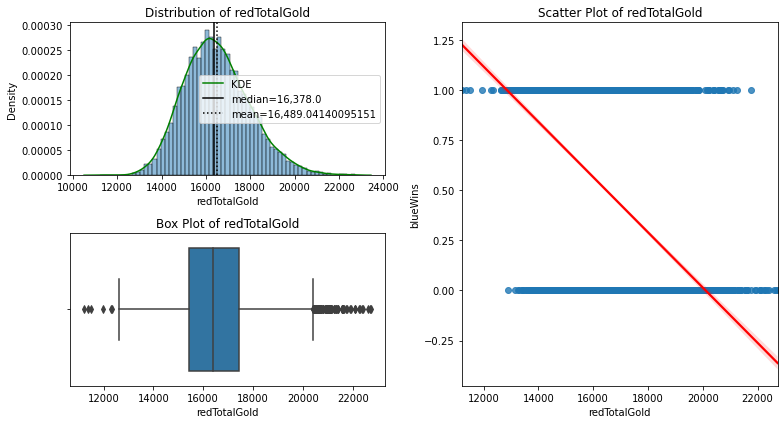

In [55]:


# Plot visualization for redTotalGold vs blueWins.
visual_eda(df_lol, 'blueWins', 'redTotalGold')



Again, we can see that we do have a lot of outliers, but the distribution of each of these features is normal. As you might have expected, we can see a generally negative correlation between red total gold and experience and a blue win, with a generally positive correlation between blue total gold and experience and a blue win.
